**Tarea 3: Regresión sobre el precio del ítem**

¿Se puede predecir el precio del ítem en base a su información? 

¿Qué tan bien funciona en validación? 

¿Qué tan bien funciona años después en versus?

In [ ]:
pip install category_encoders

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import set_config
import multiprocessing
import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
downloaded = drive.CreateFile({'id': '1re5zsZd1PlGgNcf1zQfBfQXWr8lK5u1s'})
downloaded.GetContentFile('model_backup_mlpr1')

In [ ]:
downloaded = drive.CreateFile({'id': '1lHuzdCSh7dW_8dmd6tgLge1_mWHqJ5xs'})
downloaded.GetContentFile('silkroad_items.csv')

In [ ]:
downloaded = drive.CreateFile({'id': '1YKEWXsQu2fJEFxhJtVEWVg6gM53ZyUX2'})
downloaded.GetContentFile('Bitcoin2014-2015.csv')

In [ ]:
items = pd.read_csv('silkroad_items.csv', encoding='latin-1')
items["timestamp"]=pd.to_datetime(items["timestamp"])
items["timestamp"] = items['timestamp'].dt.floor('d')

Hay varios features distintos entre el dataset y versus, como voy a tener que usar el mismo modelo para la regresión de ambos. Voy a quedarme con los datos que comparten.

Elimino columnas que no me sirven:

In [ ]:
items.drop(['image_id', 'original_path', 'description', 'ships_to', 'vendor', 'item_id'], axis = 1, inplace=True)

In [ ]:
items.head()

,title,price,category,timestamp,ships_from
0,JJ Luna privacy ebooks,0.001722,Alcohol,2014-02-23,Undeclared
1,The Morality of Capitalism,0.003443,Alcohol,2014-02-23,Undeclared
2,Survive!,0.001722,Alcohol,2014-02-23,Undeclared
3,A Non-Religious New Testament,0.015496,Alcohol,2014-02-23,Undeclared
4,Mindless Slogans: 101 Cheap Substitutes for Ac...,0.001722,Alcohol,2014-02-23,Undeclared


Paso los precios a EUROS.

In [ ]:
btc = pd.read_csv('Bitcoin2014-2015.csv', encoding='latin-1')
btc.rename(columns={'ï»¿"Date"':'Date'}, inplace=True)
btc['Date'] = pd.to_datetime(btc['Date'])
btc = btc.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)

In [ ]:
items = items.merge(btc, left_on='timestamp', right_on='Date', how='left')
btc = None

Hay algunos precios que son ridiculos (spoiler del canal de consultas). 
Así que directamente los borro.

Hay precios (btc) que estan como x.xxxe+xx, me voy a quedar con los que sean e+00 para abajo.

In [ ]:
items = items.sort_values(['price'], ascending = False).reset_index().drop(range(0,11900))
items = items.reset_index()
items.drop(['index', 'level_0'], axis=1, inplace=True)

In [ ]:
items.drop(['Date'], axis=1, inplace=True)

items['Price_EUR'] = items['price'] * items['Price']
items.drop(['Price', 'price'], axis=1, inplace=True)
items.head(3)

,title,category,timestamp,ships_from,Price_EUR
0,1000 grams of pure butylone (bk-MBDB),Ecstasy,2014-10-25,China,2758.427798
1,4-FMA - 1000g,FMA's,2014-10-25,China,2758.427798
2,THJ-2201 - 1000g,Chemicals,2014-09-15,China,3623.646734


Veo si hay productos con NaN

In [ ]:
items['Price_EUR'].isnull().values.sum()

64

Como son pocos, los voy a borrar directamente

In [ ]:
items.dropna(subset=['Price_EUR'], inplace=True)

In [ ]:
items = items.sort_values(["timestamp"])

In [ ]:
items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389130 entries, 153133 to 366185
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   title       389130 non-null  object        
 1   category    389130 non-null  object        
 2   timestamp   389130 non-null  datetime64[ns]
 3   ships_from  388969 non-null  object        
 4   Price_EUR   389130 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 17.8+ MB


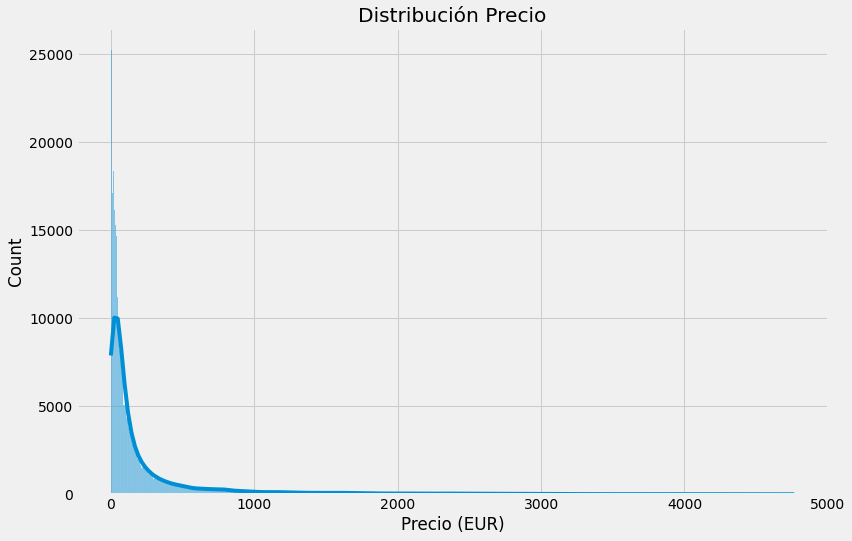

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.histplot(data=items, x='Price_EUR', kde=True,ax=ax)
ax.set_title("Distribución Precio")
ax.set_xlabel('Precio (EUR)');

Divido en entrenamiento y validacion. Sera un 80% y 20% respectivamente.

In [ ]:
train = items.iloc[:311304]
validation = items.iloc[311304:]
items = None

Divido la fecha por dia, mes y año

In [ ]:
train['Year'] = train['timestamp'].dt.year 
train['Month'] = train['timestamp'].dt.month
train['Day'] = train['timestamp'].dt.day 

train.drop('timestamp', axis=1, inplace=True)

validation['Year'] = validation['timestamp'].dt.year 
validation['Month'] = validation['timestamp'].dt.month
validation['Day'] = validation['timestamp'].dt.day 


validation.drop('timestamp', axis=1, inplace=True)

**Tema: NaN**

Si son de features numericos: no hay

Si son de features no numericos: pasaran a ser el valor 'Desconocido' (pasa a ser una categoría del feature)

In [ ]:
train.fillna('Desconocido', inplace=True)
validation.fillna('Desconocido', inplace=True)

In [ ]:
train.head(3)

,title,category,ships_from,Price_EUR,Year,Month,Day
153133,BROMAZEPAM 6mg (LEXOTAN) x50,Benzos,Sweden,81.979543,2014,2,23
364041,1x 2mg Pfizer Xanax Bar [PRE-ORDER],Alprazolam,Australia,3.784233,2014,2,23
169777,Drostanolone Propionate 100mg/mL 10ml (Gen Pha...,Anabolic Steroids,Australia,68.341093,2014,2,23


In [ ]:
x_train = train.drop('Price_EUR', axis=1)
y_train = train['Price_EUR']

x_valid = validation.drop('Price_EUR', axis=1)
y_valid = validation['Price_EUR']

train = None
validation = None

# Encoding y modelado

Voy a aplicar OHE a las variables categoricas y voy a estandarizar las variables continuas.

**Voy a realizar el encoding y el modelado todo junto.**



En gran parte me guie por esto: https://www.cienciadedatos.net/documentos/py35-redes-neuronales-python.html

In [ ]:
# Identificación de columnas numéricas y categóricas
numeric_cols = x_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_cols = x_train.select_dtypes(include=['object']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)],
                    remainder='passthrough')

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', MLPRegressor(solver = 'lbfgs', max_iter= 1000))])

Hiperparametros:  no voy a setear ninguno ya que sino tarda muchisimas horas y no queda mucho tiempo para la hora entrega :(

(Bad luck: lo habia dejado como 3hs y se me corto el internet. Ese corte me arruino jajajajaja)

In [ ]:
# Búsqueda por validación cruzada
#grid = RandomizedSearchCV(
 #       estimator  = pipe,
  #      param_distributions = {},
   #     n_iter     = 20,
    #    scoring    = 'r2',
    #    n_jobs     = 1,
    #    cv         = 5, 
    #    verbose    = 0,
    #    random_state = 40,
    #    return_train_score = True
    #   )

#grid.fit(X = x_train, y = y_train)


In [ ]:
import pickle
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#with open('model_backup_mlpr1', 'wb') as model_backup_file:
 #   pickle.dump(grid, model_backup_file)

In [ ]:
with open('model_backup_mlpr1', 'rb') as file:
    grid = pickle.load(file)

# Prediccion con el set de validacion

In [ ]:
modelo_final = grid.best_estimator_
y_pred = modelo_final.predict(X = x_valid)

In [ ]:
mean_squared_error(y_valid, y_pred)

30798.537368572066

In [ ]:
r2_score(y_valid, y_pred)

0.8481789044501705

# Versus

In [ ]:
downloaded = drive.CreateFile({'id': '12voIVKmM2EisPWQD8ickJot2nO5q1uv6'})
downloaded.GetContentFile('versus.csv')

In [ ]:
versus = pd.read_csv('versus.csv', encoding='latin-1')
versus["timestamp"]=pd.to_datetime(versus["timestamp"])
versus["timestamp"] = versus['timestamp'].dt.floor('d')

In [ ]:
versus.drop(['warnings', 'Type', 'Sales', 'Stock', 'price_unit'], axis = 1, inplace=True)
versus.rename(columns={'Category': 'category', 'From':'ships_from', 'price':'Price_EUR'}, inplace=True)
versus["Price_EUR"].replace({'EUR':''}, regex=True, inplace=True)
versus['Price_EUR'] = versus['Price_EUR'].astype(float)

In [ ]:
versus['Price_EUR'].isnull().values.sum()

0

In [ ]:
versus['Year'] = versus['timestamp'].dt.year 
versus['Month'] = versus['timestamp'].dt.month
versus['Day'] = versus['timestamp'].dt.day 

versus.drop('timestamp', axis=1, inplace=True)

In [ ]:
versus.fillna('Desconocido', inplace=True)

In [ ]:
x_test = versus.drop('Price_EUR', axis=1)
y_test = versus['Price_EUR']

In [ ]:
y_pred_test = modelo_final.predict(X = x_test)

In [ ]:
mean_squared_error(y_test, y_pred_test)

72048032.22556157

In [ ]:
r2_score(y_test, y_pred_test)

-0.0008901853091642931